In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTest import *
from backtest.regression_portfolio import *
from backtest.ptfl_optim import PtflOptimizer

from factor_mining.Mark0 import * # This is alpha file

In [2]:
%%time
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, version=5, wFund=True)
filt_na(univ)

# import warnings
# warnings.filterwarnings("ignore")

Setup R3000 universe
use existing binary file
CPU times: user 2.84 s, sys: 228 ms, total: 3.06 s
Wall time: 3.19 s


In [3]:
%%time
### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_wFund_00(univ)

factor_names = list(factors.keys())
factors_dict = factors
factor_names = [k for k in factors_dict.keys()]
N_f = len(factor_names)
datelst = sorted(factors_dict[factor_names[0]].keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

Calculate factors
CPU times: user 55.6 s, sys: 748 ms, total: 56.3 s
Wall time: 56.4 s


In [4]:
### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
# filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 300000)
filt_byval(univ, 'div_ratio', 10, keep='below')

factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1'])
print('Done')

# Preprocessing factor expsure matrices
print('Standard scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Filt the untradables
Done
Standard scale each factor
Winsorize with +/- 3 std
Done


In [6]:
%%time
start_date = np.datetime64('2014-01-01')
end_date = np.datetime64('2016-12-31')

factor_names = list(factors.keys())
optimizr = PtflOptimizer(U=0.1, L=-0.1)
spcalc = RegressionPtflSpcalc(all_factor_names=factor_names, optimzr=optimizr, smoothing='simple')
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[start_date, end_date], sp_calc=spcalc, rebal=1)
ptfl_lst, pnl_lst = bt.calc_pnl(silence=True, has_short=True)

2014-01-07T00:00:00.000000000
2014-01-14T00:00:00.000000000
2014-01-21T00:00:00.000000000
2014-01-28T00:00:00.000000000
2014-02-04T00:00:00.000000000
2014-02-11T00:00:00.000000000
2014-02-18T00:00:00.000000000
2014-02-25T00:00:00.000000000
2014-03-04T00:00:00.000000000
2014-03-11T00:00:00.000000000
2014-03-18T00:00:00.000000000
2014-03-25T00:00:00.000000000
2014-04-01T00:00:00.000000000
2014-04-08T00:00:00.000000000
2014-04-15T00:00:00.000000000
2014-04-22T00:00:00.000000000
2014-04-29T00:00:00.000000000
2014-05-06T00:00:00.000000000
2014-05-13T00:00:00.000000000
2014-05-20T00:00:00.000000000
2014-05-27T00:00:00.000000000
2014-06-03T00:00:00.000000000
2014-06-10T00:00:00.000000000
2014-06-17T00:00:00.000000000
2014-06-24T00:00:00.000000000
2014-07-01T00:00:00.000000000
2014-07-08T00:00:00.000000000
2014-07-15T00:00:00.000000000
2014-07-22T00:00:00.000000000
2014-07-29T00:00:00.000000000
2014-08-05T00:00:00.000000000
2014-08-12T00:00:00.000000000
2014-08-19T00:00:00.000000000
2014-08-26

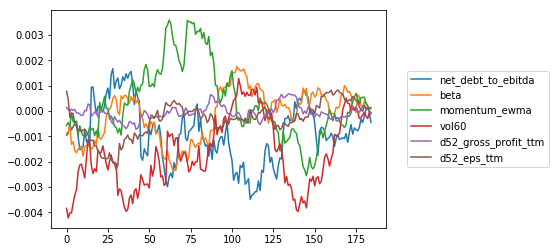

In [7]:
fr_series = np.stack(fr['factor_returns'] for fr in spcalc.all_factor_returns.values())
window = 30
ck = np.ones((window,)) / window
for c in range(6):
    fr_series[:,c] = np.convolve(ck, fr_series[:,c])[window-1:]
    plt.plot(fr_series[:,c], label=spcalc.all_factor_names[c])
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

In [8]:
bt.calc_pa(silent=False)

CAGR :	 0.179051131962
Volatility :	 0.327889648684
Sharpe :	 0.502333605835
Max_Drawdown :	 0.358740882524
Drawdown_Length :	 81


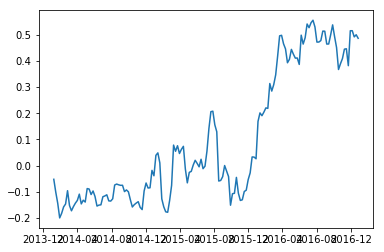

In [9]:
dlst = sorted(univ.keys())
dlst = [d for d in dlst if d >= start_date and d <= end_date]
plt.plot(dlst, np.cumsum(pnl_lst['pnl']))
plt.show()

In [10]:
tstamp = str(datetime.now())
bt.pnl_lst.to_csv('output/pnl_%s.csv' % tstamp)

In [11]:
ptfl_lst = pd.concat(bt.ptfl_lst)
pp = pd.pivot_table(ptfl_lst, values='weight', columns='ticker', index='date')
pp.to_csv('output/portfolio_table_%s.csv' % tstamp)

In [12]:
pnl_lst.iloc[np.argsort(pnl_lst.pnl)[:10],:]

,date,pnl
84,2015-08-18,-0.187932
55,2015-01-27,-0.137176
90,2015-09-29,-0.109101
67,2015-04-21,-0.086659
145,2016-10-18,-0.083875
150,2016-11-22,-0.064505
94,2015-10-27,-0.060215
134,2016-08-02,-0.057657
8,2014-03-04,-0.056528
3,2014-01-28,-0.056035


In [20]:
w = pp.iloc[84,:]

In [28]:
w.dropna(inplace=True)
ww = w[w != 0]

In [29]:
ww

ticker
AAPL UW Equity     0.053724
BTUUQ UN Equity   -0.200001
DYAX UQ Equity     0.200001
FB UW Equity       0.168087
GILD UW Equity     0.200001
LL UN Equity      -0.063914
PANW UN Equity     0.200001
PRTA UW Equity     0.200001
QLIK UW Equity     0.200001
SPXC UN Equity    -0.200001
TMUS UN Equity     0.078185
TNET UN Equity    -0.036085
UNH UN Equity      0.200001
Name: 2015-08-18 00:00:00, dtype: float64

In [24]:
univ_table = stack(univ)

In [27]:
t = univ_table[univ_table.date == np.datetime64('2015-08-18')]

In [58]:
ix = pd.DataFrame(ww).index.tolist()
t.loc[ix,'f_log_ret_1']

ticker
AAPL UW Equity    -0.116004
BTUUQ UN Equity    0.387447
DYAX UQ Equity    -0.073411
FB UW Equity      -0.136824
GILD UW Equity    -0.132238
LL UN Equity      -0.016173
PANW UN Equity    -0.091918
PRTA UW Equity    -0.139787
QLIK UW Equity    -0.144291
SPXC UN Equity    -0.158461
TMUS UN Equity    -0.097620
TNET UN Equity    -0.098571
UNH UN Equity     -0.132009
Name: f_log_ret_1, dtype: float64